In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot
import scipy.ndimage as ndi

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/plot.py'>

In [3]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/paper_utils.py'>

In [5]:
# Ps = classifier.get_P() # category, icc in MCM, 2**rank_icc probability distribution
# MCMs = classifier.get_MCMs()
# Counts = classifier.get_Counts()
# N = Counts[0][0].sum().astype(int) 

In [20]:
digit = 0

sample_sizes = [6315]

path_format = "../OUTPUT/sample_sizes_fromfull"

counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, "",path_format)
counts_samplesizes, mcms_samplesizes = counts_samplesizes[0][0], mcms_samplesizes[0][0]

In [18]:
len(Counts)

1

In [21]:
Counts = counts_samplesizes
MCMs = mcms_samplesizes
N = sample_sizes[0]


In [23]:
import math
mcm_idx = 0

import numpy as np
import math

def evidence_iccs(Counts, MCMs, mcm_idx):
    """Calculate the evidence for each icc in an MCM.
      Return an array of evidences. The sum of that array is the MCM evidence.

    :param Counts: Return value of classifier.get_Counts(). Unormalized probability distribution for all MCM for all ICC.  
    :type Counts: np.ndarray of shape[category,icc,possible_states]
    :param MCMs: Return value of classifier.get_MCMs(). MCMs for all categories.
    :type MCMs: np.ndarray of shape[category,icc] of binary strings.
    :param mcm_idx: which mcm to calculate the evidence for.
    :type mcm_idx: int < #categories
    :return: np.ndarray of evidences for each icc. ICC are identified by index
    :rtype: np.ndarray of shape [icc_evidences]
    """
    N = np.array(Counts[0][0]).sum().astype(int) 
    count_mcm = Counts[mcm_idx]
    evidence = np.zeros(len(count_mcm))
    log_sqrt_pi = math.log(math.sqrt(math.pi))
    for idx, icc in enumerate(count_mcm):
        rank = MCMs[mcm_idx][idx].count("1")
        evidence[idx] += math.lgamma(2**(rank-1)) - math.lgamma(N + 2**(rank-1)) # middle part of equation 8 in Mulatier_2020
        for pattern in Counts[mcm_idx][idx]: # last part of equation 8
            evidence[idx] += math.lgamma(pattern+.5) - log_sqrt_pi
    return evidence

evidence_iccs(Counts,MCMs,2)


array([ -7130.8061298 , -22507.37583608,   -735.82749956, -26041.61234773,
       -25829.96021445, -30098.27548789,   -394.7359659 , -26283.76891124,
          -91.78253146,   -494.91185985, -15416.52774233,  -2281.48499362,
       -20364.34889257,  -8122.42458843,    -40.93073329,  -3990.26096518,
       -19852.077149  , -14017.08839062, -32303.68448672,   -814.06742236,
         -834.44012617])

In [24]:
def pixelwise_evidence(evidence_iccs,N,single_mcm):
    icc_pixels = [icc.count("1") for icc in single_mcm]
    return evidence_iccs / np.log(2) / N / icc_pixels

In [8]:
# import matplotlib.colors as mcolors

# def cmap_to_gray(color, reverse=False):
#     """
#     Create a colormap from the specified color to grey.

#     Parameters:
#     - color (str): The color to start the colormap from. This can be any color name recognized by Matplotlib.
#     - reverse (bool, optional): Whether to reverse the colormap. Defaults to False.

#     Returns:
#     - A Matplotlib colormap.
#     """
#     cmap = mcolors.LinearSegmentedColormap.from_list("", [color, "whitesmoke"])
#     if reverse:
#         cmap = cmap.reversed()
#     return cmap

In [29]:
evds = []
comms = []
mcm_idxs =np.arange(10)
cmap = myplot.cmap_to_gray("royalblue", reverse=False)

for mcm_idx in mcm_idxs:
    comms.append(myplot.generate_icc_comms_map(MCMs[mcm_idx]))
    evd = evidence_iccs(Counts,MCMs,mcm_idx)
    evd = pixelwise_evidence(evd,N,MCMs[mcm_idx]) 
    evds.append(evd)

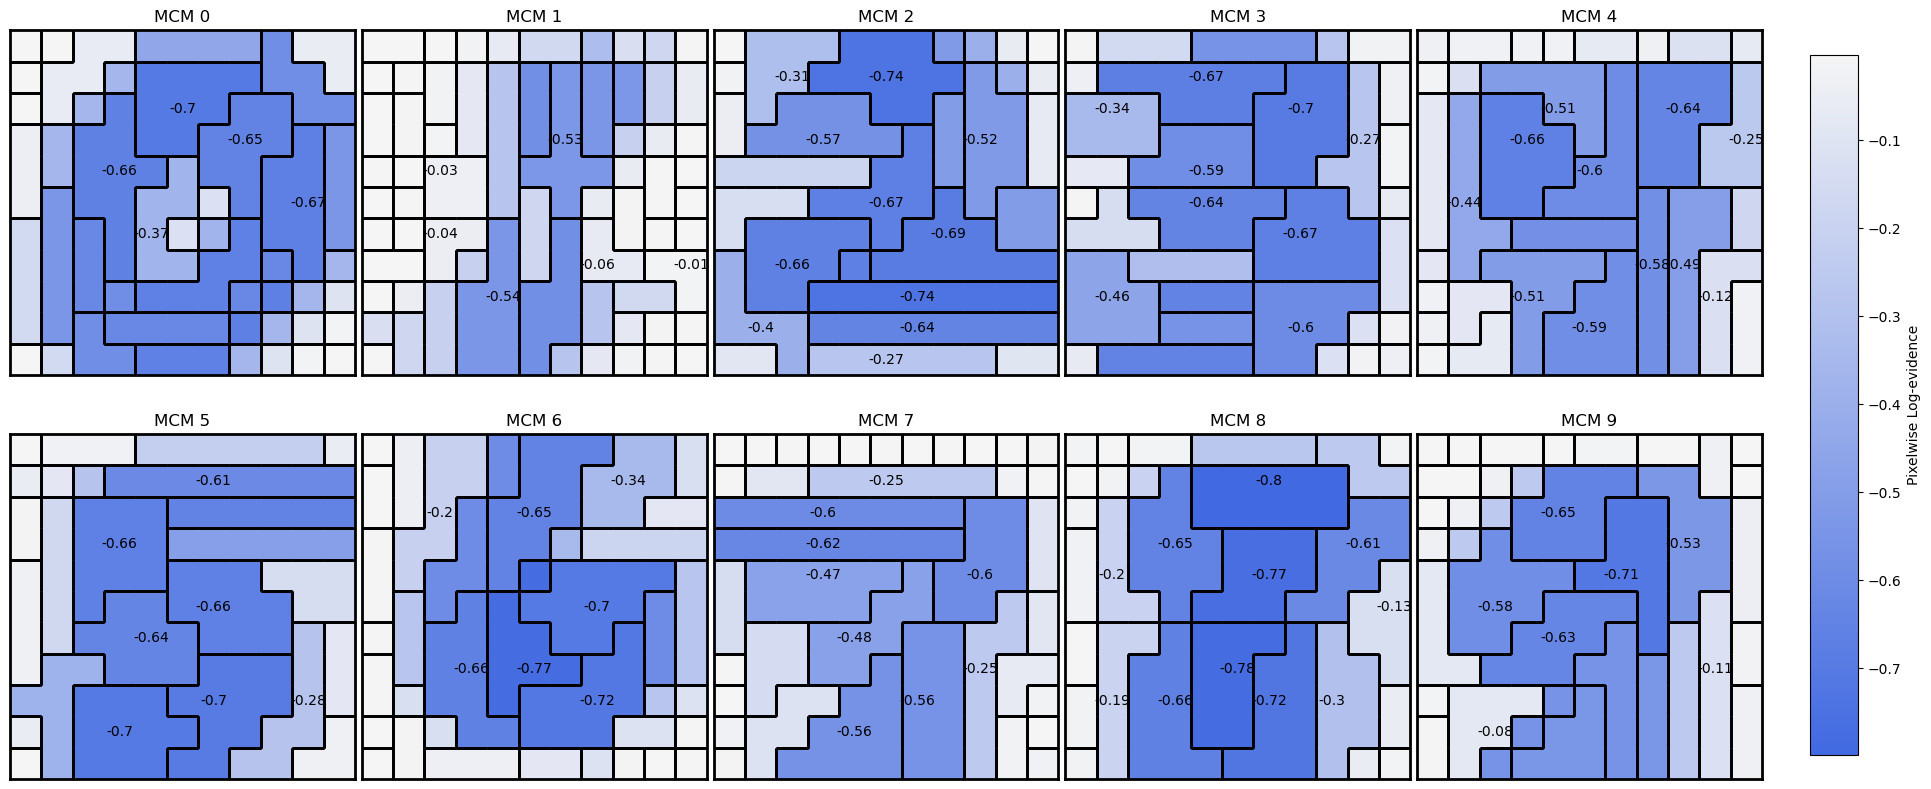

In [32]:




# for mcm_idxs in [[0,1,2,3],[4,5,6,7],[8,9,0,0]]:
scale = 2
fig, axs  = plt.subplots(2,5,figsize=(12*scale,5*scale))
axs = axs.flatten()



global_vbounds = np.min([np.min(i) for i in evds]), np.max([np.max(i) for i in evds])

for ax_i, mcm_idx in enumerate(mcm_idxs):
    val_matrix = evds[ax_i][comms[ax_i]]
    axs[ax_i].set_title("MCM %d" % (mcm_idx))
    im = myplot.partition_map(axs[ax_i],val_matrix,None,myplot.find_borders(comms[ax_i]),drawing_cond=lambda x: True,
                                normalise=False,global_vbounds=global_vbounds,cbar=False,cmap=cmap)    
    myplot.label_communities(comms[ax_i],axs[ax_i],evds[ax_i].round(2),color="black") 
                    
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83,
                    wspace=0.02, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("test.png", dpi=300, bbox_inches="tight")

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Pixelwise Log-evidence')


# plt.suptitle("Pixelwise log-evidence")
# plt.tight_layout()
plt.savefig("../figures/paper_evidence_pixelwise.png",dpi=300,bbox_inches="tight")



- Pixelwise log-evidence for each icc (/log(2)/nr_images/nr_pixel_in_icc)
- grey areas have highest values -> are most compressible ones
- may be that these areas are very indivative as they are usually not part of the digit. So if they are lit, then its likly not the same digit (see MCM1 vs MCM0 for example.)

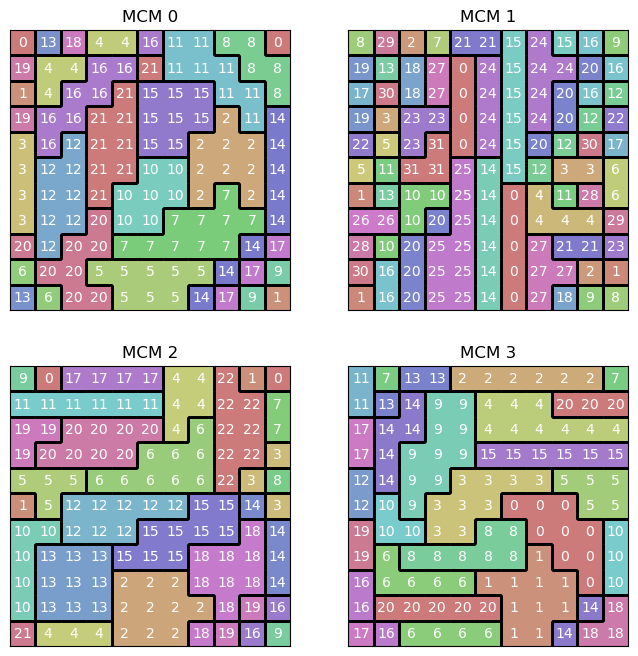

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):  
    myplot.plot_communities(axs[i],comms[i],f"MCM {i}")
plt.show()

In [ ]:
# # Customizable environment variables
# n_categories = 10  # Number of categories to be classified
# n_variables = 121  # Number of variables in the dataset
# mcm_filename_format = "train-images-unlabeled-{}_bootstrap_comms.dat"
# data_filename_format = "train-images-unlabeled-{}.dat"
# data_path = "../all_INPUT/data/"
# communities_path = "../OUTPUT/comms/"
# output_path = "../OUTPUT/"
# print("{:-^50}".format("  MCM-Classifier  ")) 

# # test_data = load_data("../INPUT/data/test-images-unlabeled-all-uniform.txt").astype(int)
# # test_labels = load_labels("../INPUT/data/test-labels-uniform.txt").astype(int)

# # Step 1: Initialize classifier
# classifier = MCM_Classifier(n_categories, n_variables, mcm_filename_format, data_filename_format, data_path, communities_path)

# # Step 2: Train
# classifier.fit(greedy=True, max_iter=1000000, max_no_improvement=100000)


# # # Step 3: Evaluate
# # predicted_classes, probs = classifier.predict(test_data, test_labels)

# # # Step 4: Save classification report and other stats
# # # report = classifier.get_classification_report(test_labels)
# # classifier.save_classification_report(test_labels,path=output_path)

# # if (classifier.stats == None):
# #     raise Exception("Classifier stats not found. Did you forget to call predict()?")
